In [ ]:
import pandas as pd 
import numpy as np
from src.download import *
import zipfile 
import glob
from tqdm import tqdm  
import os
from src.files.fasta import FASTAFile
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score, completeness_score
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.stats import entropy 
import re
import subprocess
import math 
from utils import * 
from src.data import *
import matplotlib.cm 
import matplotlib.colors

%load_ext autoreload
%autoreload 2


niks_domain = 'YxCxxxF'
ycf_domain = 'Y.C'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
arf1_df = pd.read_csv('../data/arf1_cleaned.csv', index_col=0)

def load_msa(path:str='../data/arf1_cleaned.afa', ids:list=arf1_df.index):
    msa_df = FASTAFile().from_fasta(path).to_df()
    msa_df = msa_df.loc[ids].copy()
    msa_arr = [list(seq) for seq in msa_df.seq]
    return msa_df.index.values, np.array(msa_arr)

index, alignment = load_msa()

In [ ]:
conservation_threshold = 0.8
# Flag conserved positions as those where at least 80 percent of the sequences do not have a gap. 
is_conserved = lambda col : (col != '-').astype(int).mean() > conservation_threshold

conserved_positions = np.where([is_conserved(col) for col in alignment.T])[0]
print('Num. conserved positions:', len(conserved_positions))

alignment = alignment[:, conserved_positions] # Ignore the extra junk in the alignment. 

seq = ''.join(alignment[0]) # The first entry in the alignment has the canonical YxCxxxF domain and YXCXXXF.

niks_match = re.search(niks_domain, seq)
ycf_match = re.search(ycf_domain, seq, flags=re.DOTALL)

start, stop = ycf_match.start(), ycf_match.end()

# There are some clear outliers, potentially worth discarding for a better alignment.

# There are like 2 cases where the C is not conserved, which seems to be skewing the MI plot.
keep_idxs = np.where(alignment[:, 121].ravel() == 'C')[0]
alignment = alignment[keep_idxs, :].copy() 
# np.unique(alignment[:, 121].ravel(), return_counts=True)
# np.unique(alignment[:, 119].ravel(), return_counts=True)

Num. conserved positions: 408


In [38]:
if not os.path.exists('../data/mutual_information_no_outliers.txt'):
    h = mutual_information(alignment)
    h[h == 1] = np.nan
    with open('../data/mutual_information_no_outliers.txt', 'w') as f:
        np.savetxt(f, h)
else:
    with open('../data/mutual_information_no_outliers.txt', 'r') as f:
        h = np.loadtxt(f)



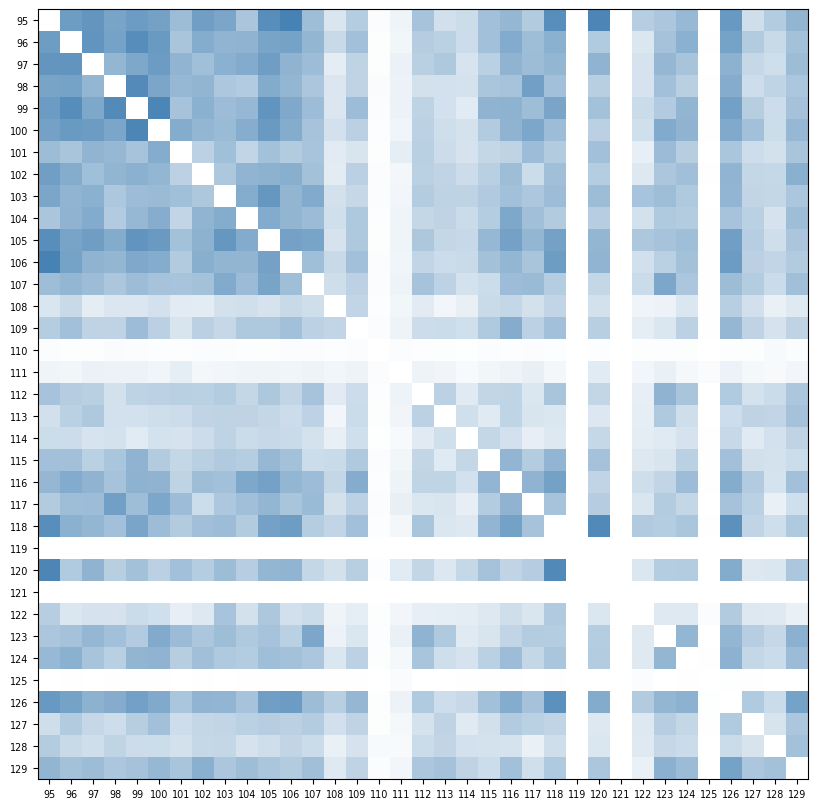

In [40]:
def figure(h:np.ndarray, start=95, stop=130):
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('palette', ['white', 'steelblue'])

    fig, ax = plt.subplots(figsize=(10, 10))
    plt.imshow(h[start:stop, start:stop], cmap=cmap)
    ax.set_xticks(np.arange(stop - start), labels=np.arange(start, stop), fontsize='x-small')
    ax.set_yticks(np.arange(stop - start), labels=np.arange(start, stop), fontsize='x-small')
    plt.show()

figure(h)

In [10]:
# cmap = matplotlib.colors.LinearSegmentedColormap.from_list('palette', ['white', 'steelblue'])
# positions = np.array([52, 67, 70, 74])

# start, stop = 50, 90
# fig, ax = plt.subplots(figsize=(8, 10))
# plt.imshow(h[positions, start:stop], cmap=cmap)
# ax.set_yticks(np.arange(len(positions)), labels=positions, fontsize='x-small')
# ax.set_xticks(np.arange(stop - start), labels=np.arange(start, stop), fontsize='x-small')
# plt.show()

In [11]:
alignment_df = pd.DataFrame(alignment, index=index)
alignment_df['group'] = np.where(arf1_df.has_pyl, 'pyl', 'no_pyl')

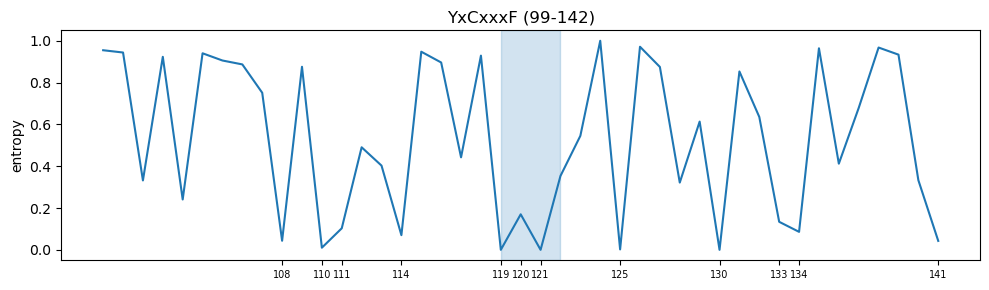

In [42]:
def figure(alignment:np.ndarray, start:int=None, stop:int=None, delta:int=20, highlight:tuple=None, title:str=None, max_entropy:float=0.2):
    fig, ax = plt.subplots(figsize=(10, 3))

    alignment = alignment[:, start - delta:stop + delta].copy() # start - delta is the new zero. 
    offset = (start - delta)

    for aa, symbol in dayhoff.items():
        alignment[alignment == aa] = symbol

    probabilities = [[(column == aa).mean() for aa in column] for column in alignment.T]
    entropies = np.array([-sum([p_ * math.log(p_, len(p)) for p_ in p]) for p in probabilities])
    entropies = entropies / entropies.max()

    sns.lineplot(x=np.arange(len(entropies)), y=entropies, ax=ax)

    x_ticks = np.where(entropies < max_entropy)[0]
    ax.set_xticks(x_ticks, labels=x_ticks + offset, fontsize='x-small')
    ax.set_title(f'{title} ({start - delta}-{stop + delta})')
    ax.set_ylabel('entropy')

    if highlight is not None:
        x_min, x_max = highlight
        ax.axvspan(x_min - offset, x_max - offset, alpha=0.2, color='tab:blue')

    fig.tight_layout()
    plt.show()

    return np.where(entropies < max_entropy)[0] + offset, entropies

positions, entropies = figure(alignment, start=start, stop=stop, highlight=(start, stop), title='YxCxxxF', max_entropy=0.2)
# positions = figure(alignment, start=ycf_start, stop=ycf_stop, highlight=(ycf_start, ycf_stop), title='YxCxxxF', max_entropy=20)

In [13]:
def figure_2(alignment:np.ndarray, start:int=None, stop:int=None, delta:int=20, color:str=None, ax=None, label=None, scale:np.ndarray=None):

    alignment = alignment[:, start - delta:stop + delta] # start - delta is the new zero. 
    offset = (start - delta)

    for aa, symbol in dayhoff.items():
        alignment[alignment == aa] = symbol
    # conserved = [np.all(column == column[0]) for column in alignment.T]
    # print('Num. completely conserved residues:', sum(conserved))

    probabilities = [[(column == aa).mean() for aa in column] for column in alignment.T]
    entropies = np.array([-sum([p_ * math.log(p_, len(p)) for p_ in p]) for p in probabilities])
    entropies = entropies / entropies.max() # Normalize the entropies to 1. 
    x_ticks = np.where(entropies < 0.25)[0]
    
    if scale is not None:
        entropies = entropies - scale

    sns.lineplot(x=np.arange(len(entropies)), y=entropies, ax=ax, color=color, label=label)
    
    ax.set_xticks(x_ticks, labels=x_ticks + offset, fontsize='x-small')
    ax.set_ylabel('entropy')

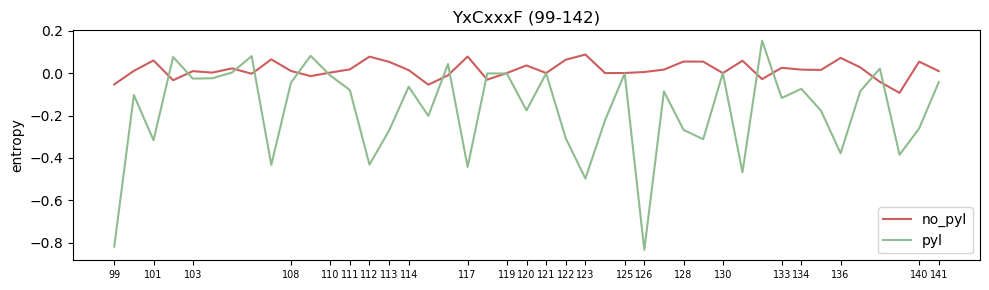

In [41]:
palette = {'pyl':'darkseagreen', 'no_pyl':'indianred'}

delta = 20
fig, ax = plt.subplots(figsize=(10, 3))
for group, df in alignment_df.groupby('group'):
    figure_2(df.values, start=start, stop=stop, color=palette[group], ax=ax, label=group, scale=entropies)
ax.set_title(f'YxCxxxF ({start - delta}-{stop + delta})')
ax.legend()

fig.tight_layout()
plt.show()

In [15]:
def figure_3(alignment_df:pd.DataFrame, position:int=None, palette={'pyl':'darkseagreen', 'no_pyl':'indianred'}, ax=None):
    # fig, (ax_top, ax_bottom) = get_split_figure((0, 0.0025), (0.97, 0.98))

    figure_df = alignment_df[['group', position]].copy()
    sns.histplot(figure_df, x=position, hue='group', multiple='dodge', ax=ax, palette=palette)
    ax.set_ylabel('count')
    # ax.set_yscale('log')
    ax.get_legend().set_title('')
    ax.set_xlabel('')
    ax.set_title(f'position {position}')

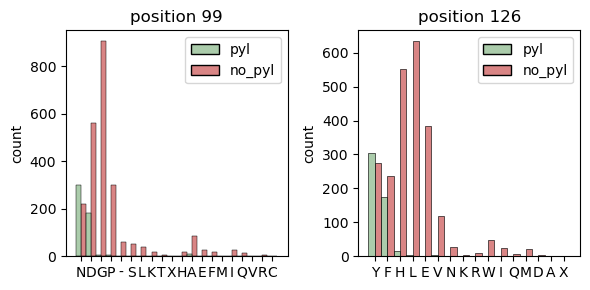

In [44]:
positions = [99, 126]
fig, axes = plt.subplots(ncols=len(positions), figsize=(3 * len(positions), 3))
for ax, position in zip(axes.ravel(), positions):
    figure_3(alignment_df, position=position, ax=ax)
fig.tight_layout()
plt.show()

# Q is glutamine, polar and uncharged. 
# S is serine, polar and uncharged. 
# A is alanine, small and hydrophobic. 
# T is threonine, polar and uncharged. 
# E is glutamic acid, which is negatively-charged. 

# Glutamine can generate stronger hydrogen bonds than serine. 

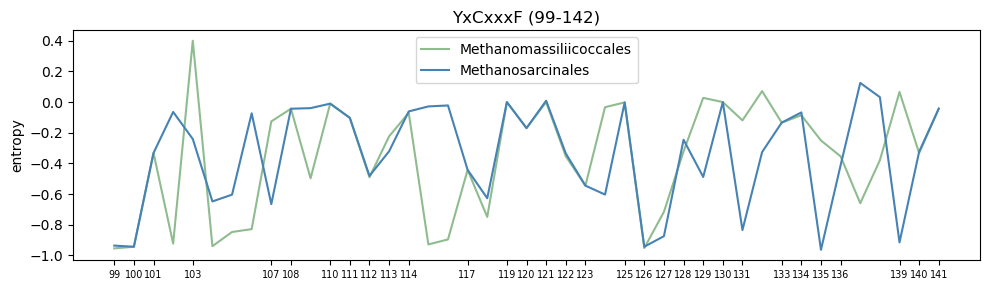

In [45]:
palette = {'Methanosarcinales':'steelblue', 'Methanomassiliicoccales':'darkseagreen'}

figure_df = alignment_df.copy()
figure_df['group'] = arf1_df['order'].values
figure_df = figure_df[arf1_df.has_pyl].copy()
figure_df['group'] = np.where(~figure_df['group'].isin(palette.keys()), 'other', figure_df['group'])
figure_df = figure_df[figure_df.group != 'other'].copy()

delta = 20
fig, ax = plt.subplots(figsize=(10, 3))
for group, df in figure_df.groupby('group'):
    figure_2(df.values, start=start, stop=stop, color=palette.get(group, 'gray'), ax=ax, label=group, scale=entropies)
ax.set_title(f'YxCxxxF ({start - delta}-{stop + delta})')
# ax.axhline(1, color='gray', ls='--', lw=0.7)
# ax.set_ylim(ymax=1, ymin=0)
fig.tight_layout()
plt.show()

In [18]:
pyl_idxs = np.where(arf1_df.has_pyl)[0]
no_pyl_idxs = np.where(~arf1_df.has_pyl)[0]

pyl_alignment = alignment[pyl_idxs].copy()
no_pyl_alignment = alignment[no_pyl_idxs].copy()

positions = [67, 70, 74]

pyl_alignment = [''.join(residues) for residues in pyl_alignment[:, positions]]
no_pyl_alignment = [''.join(residues) for residues in no_pyl_alignment[:, positions]]

In [19]:
seq = alignment[pyl_idxs[0]] # [positions]
seq = ''.join(seq)
seq

'MTEQSAHEKYEFKKKLEGLRDKKGRSTELISLYIPPDKQIFDVTNQLKDEHGQAANIKSKLTRTNVQGAIESLLSRLRYLDKVPENGIVYFTGAVDIGANKTSMESEVIVPPDPITVYKYHCDSSFYLEPLEDMLKDKNTYGLLVLDRREATIGLLVGKRIQPFRNLTSTVPGKQRKGGQSAHRFQQLRLIAIHDFYKRIGDAASEVFMAVKDLKGVLIGGPSPTKEEFHAGEFLHHELMKKILGLFDTAYTDESGLSELVNAAGEKLQDLELMGQKNAVRDFFKELIASGKVAYGESQVRANLEINSVDVLLLSEDLRAERVTTKCSVCGYENKWTRRWKAPAAGNCPKCGSSLEVTDVTDIVDEFSELADKSNAKVVFVSTDFDEGSQLMNAFGGIAAILRYNTV*'

In [20]:
kmers, counts = np.unique(pyl_alignment, return_counts=True)
kmers = kmers[np.argsort(counts)[::-1]]
counts = np.sort(counts)[::-1]

for kmer, count in zip(kmers, counts):
    print(count, kmer)

216 GES
80 GEA
44 SDS
42 GDA
39 GDS
38 SDA
6 GQA
5 NVQ
4 DVQ
4 EDA
4 SDG
3 SVQ
3 SES
3 SEQ
2 SEA
2 EHA
1 SDQ
1 STQ
1 NEN
1 NEA
1 GGA
1 GSS
1 DEQ
1 AEQ


In [21]:
kmers, counts = np.unique(no_pyl_alignment, return_counts=True)
kmers = kmers[np.argsort(counts)[::-1]]
counts = np.sort(counts)[::-1]

for kmer, count in zip(kmers, counts):
    print(count, kmer)

397 DTD
199 SSS
135 GES
115 DTQ
110 DGQ
93 DEQ
88 DVQ
76 GEQ
72 DSQ
72 SES
68 SEQ
67 DKD
61 WEG
55 SSA
53 AES
40 DSE
39 SEA
26 DES
22 DSG
21 AEQ
20 GEN
19 ASS
19 DSA
19 DEA
15 DTE
15 GDQ
15 QEQ
14 SDQ
14 DEN
13 DEH
13 DSS
11 SDS
11 GDS
10 AEN
10 EVQ
9 WDG
9 STA
8 WEN
8 DGS
8 AEA
7 NEQ
7 EEQ
6 DAN
6 DGR
6 ETQ
6 SEN
6 GSA
6 SDA
5 GQA
5 EEN
5 GKN
5 WDN
5 ASN
5 DIQ
5 GRN
5 GRG
5 DTA
5 ADR
5 ADQ
5 DAG
4 GAQ
4 DAQ
4 SRG
4 AKQ
4 QES
4 DVE
4 DKQ
3 ATA
3 DTG
3 DNG
3 GEA
3 NAA
3 GTA
3 SEG
3 ARS
3 AAN
3 TEQ
3 TEN
3 DDQ
3 DQQ
2 NEG
2 GSS
2 AQA
2 AEH
2 DNE
2 DEG
2 DMQ
2 ADN
2 SER
2 SSD
2 TER
2 SKN
2 GEH
2 GEG
2 QEN
2 NTE
2 QTA
2 SEH
2 SDR
2 SDG
2 GAS
2 EKQ
2 EEG
2 GER
2 ARN
2 DAA
2 GET
1 XES
1 SQA
1 SNG
1 SNA
1 SKQ
1 SQS
1 SRS
1 SQG
1 STQ
1 TES
1 TGQ
1 TDR
1 NGQ
1 QDS
1 SAQ
1 GMQ
1 GKA
1 DVD
1 EDN
1 EDQ
1 ETH
1 ERQ
1 ESG
1 EKH
1 EES
1 GDH
1 GDN
1 EYS
1 NEN
1 GQQ
1 GNN
1 DRA
1 DQA
1 DGE
1 DKK
1 DTK
1 DTN
1 DSN
1 DRD
1 DAS
1 DDN
1 AQV
1 ASA
1 ASQ
1 AKS
1 AQG
1 AQS
1 AAV
1 AAS
